In [72]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from tqdm import tqdm
from geopy.geocoders import Nominatim
from time import sleep
from geopy.geocoders import OpenCage
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import contextily as ctx
from opencage.geocoder import OpenCageGeocode
import folium

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [73]:
collisions_file_path = r'/Users/aarohigoel/Documents/JuneSCIntern/sc_loc2018.csv'
urban_rural_file_path = r'/Users/aarohigoel/Documents/JuneSCIntern/County_Rural_Lookup.xlsx'

collisions_df = pd.read_csv(collisions_file_path)
urban_rural_df = pd.read_excel(urban_rural_file_path)

In [74]:
urban_rural_df_cleaned = urban_rural_df.iloc[3:].copy()
urban_rural_df_cleaned.columns = ['GEOID', 'State', 'County', 'Note', 'Total_Population', 'Urban_Population', 'Rural_Population', 'Percent_Rural']
urban_rural_df_cleaned = urban_rural_df_cleaned[['GEOID', 'State', 'County', 'Total_Population', 'Urban_Population', 'Rural_Population', 'Percent_Rural']]

urban_rural_df_cleaned = urban_rural_df_cleaned.dropna(subset=['Total_Population', 'Urban_Population', 'Rural_Population'])
urban_rural_df_cleaned.head()

,GEOID,State,County,Total_Population,Urban_Population,Rural_Population,Percent_Rural
3,01001,AL,"Autauga County, Alabama",54571,31650,22921,42.002162
4,01003,AL,"Baldwin County, Alabama",182265,105205,77060,42.279099
5,01005,AL,"Barbour County, Alabama",27457,8844,18613,67.789635
6,01007,AL,"Bibb County, Alabama",22915,7252,15663,68.352607
7,01009,AL,"Blount County, Alabama",57322,5760,51562,89.951502


In [76]:
sc_urban_rural_df_cleaned = urban_rural_df_cleaned.iloc[2321:2362]
print(sc_urban_rural_df_cleaned)

      GEOID State                               County Total_Population Urban_Population Rural_Population Percent_Rural
2324  45011    SC      Barnwell County, South Carolina            22621             3949            18672      82.54277
2325  45013    SC      Beaufort County, South Carolina           162233           130360            31873     19.646434
2326  45015    SC      Berkeley County, South Carolina           177843           126351            51492     28.953628
2327  45017    SC       Calhoun County, South Carolina            15175                0            15175           100
2328  45019    SC    Charleston County, South Carolina           350209           312103            38106     10.880931
2329  45021    SC      Cherokee County, South Carolina            55467            21556            33786     60.911894
2330  45023    SC       Chester County, South Carolina            33140             9351            23789     71.783343
2331  45025    SC  Chesterfield County, 

In [75]:
county_rural_df = pd.read_csv('/Users/aarohigoel/Documents/JuneSCIntern/sc_county_rural_lookup.csv') 
merged_df = pd.merge(collisions_df,  
                     county_rural_df,  
                     on ='cty',  
                     how ='left') 
merged_df

,ano,tway,typ,day,rai,loa,odr,alc,wcc,ahc,rsc,hel,xwk,dat,als,jur,fat,inj,acd,bir,bra,sic,sra,alsb,alss,hzd,bus,trm,tow,lat,lon,jct,ocf1,ocf2,ocf3,ocf4,ibus,wzn,wzt,wzl,wpr,bno,tct,unt,cty,rtn,brn,srn,fhe,prc,tim,bdo,pnt,pat,rct,adid,dlr,CountyName,Rural/Urban Status
0,18000001,1,L,6,0.0,1.0,S,1,1,1,1,5,2,21189.0,HARRY C RAYSOR DR,0902,0.0,1.0,NaN,2,0.0,3,0.0,NaN,BRIDGES,NaN,NaN,1.0,1.0,33393110,80462302,4,1.0,NaN,NaN,NaN,3,2,NaN,NaN,NaN,65,2,2,9,601.0,601.0,6.0,22,2,948,0001,948,952,2,NO,S,"Calhoun County, South Carolina",Completely Rural
1,18000002,2,L,2,0.0,2.0,N,5,1,1,1,5,2,21185.0,MEETING STREET,1001,0.0,1.0,NaN,5,0.0,5,0.0,LINE STREET,SHEPPARD STREET,NaN,NaN,NaN,NaN,0,0,13,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,2294,98,2,10,107.0,0.0,0.0,22,8,145,0000,150,155,4,NO,N,"Charleston County, South Carolina",Urban
2,18000003,3,L,2,0.0,3.0,S,5,1,2,1,8,2,21185.0,SAM RITTENBERG BLVD,1001,0.0,0.0,NaN,1,0.0,5,0.0,NaN,POSTON RD,NaN,NaN,NaN,NaN,0,0,13,6.0,NaN,NaN,NaN,3,2,NaN,NaN,NaN,1388,98,1,10,7.0,26.0,0.0,19,16,150,0050,151,156,3,YES,N,"Charleston County, South Carolina",Urban
3,18000004,4,L,2,0.0,2.0,E,5,1,1,1,5,1,21185.0,LINE STREET,1001,0.0,1.0,NaN,4,0.0,4,0.0,COMING STREET,SAINT PHILIP STREET,NaN,NaN,NaN,NaN,0,0,4,15.0,NaN,NaN,NaN,3,2,NaN,NaN,NaN,2150,1,2,10,0.0,553.0,106.0,22,16,218,0000,218,218,5,YES,E,"Charleston County, South Carolina",Urban
4,18000005,1,L,2,0.0,2.0,S,2,3,1,1,4,2,21185.0,ELIZABETH STREET,1001,0.0,0.0,NaN,5,0.0,4,0.0,CHARLOTTE STREET,JOHN ST,NaN,NaN,NaN,NaN,0,0,13,1.0,NaN,NaN,NaN,3,2,NaN,NaN,NaN,2405,98,2,10,0.0,0.0,118.0,25,7,715,0002,716,725,5,NO,N,"Charleston County, South Carolina",Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142401,18693233,1,L,1,0.0,1.0,N,7,1,1,1,4,2,21478.0,ANTLER DR,1008,0.0,0.0,NaN,4,0.0,4,0.0,OLD UNIVERSITY BLVD,FAWN ST,NaN,NaN,NaN,NaN,32581196,80025154,13,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,6115,98,1,10,821.0,2532.0,1429.0,55,2,225,0004,227,227,4,NO,N,"Charleston County, South Carolina",Urban
142402,18693234,1,L,4,0.0,1.0,N,2,1,1,1,5,2,21369.0,N OLD RIVER ROAD,2100,0.0,0.0,NaN,5,0.0,5,0.0,BOLING ROAD,CYPRESS RD,NaN,NaN,NaN,NaN,34014436,79315318,13,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,2043,98,1,21,57.0,NaN,NaN,20,60,558,0093,529,558,4,NO,N,"Florence County, South Carolina",Urban
142403,18693235,1,L,6,0.0,NaN,S,7,1,1,1,5,2,21476.0,S OLD RIVER ROAD,2100,0.0,0.0,NaN,5,0.0,4,0.0,EVANS FARM ROAD,E BAZEN ROAD,NaN,NaN,NaN,NaN,33574518,79304813,13,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,7280,98,1,21,57.0,NaN,66.0,20,60,610,0011,615,652,4,NO,NaN,"Florence County, South Carolina",Urban
142404,18693236,3,L,6,0.0,1.0,E,1,2,1,2,4,2,21532.0,I 526,1008,0.0,0.0,NaN,4,0.0,5,0.0,VIRGINIA AVE,PINEFIELD DRIVE,NaN,NaN,NaN,NaN,32532857,79574943,13,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,6115,98,2,10,526.0,58.0,NaN,22,18,650,0287,656,704,1,NO,E,"Charleston County, South Carolina",Urban


In [8]:
#merged_df.to_csv('/Users/aarohigoel/Documents/JuneSCIntern/collision_df_county.csv')

In [77]:
merged_df['Rural/Urban Status']

0         Completely Rural
1                    Urban
2                    Urban
3                    Urban
4                    Urban
                ...       
142401               Urban
142402               Urban
142403               Urban
142404               Urban
142405               Urban
Name: Rural/Urban Status, Length: 142406, dtype: object

In [90]:
merged_df['Rural/Urban Status'].value_counts()

Rural/Urban Status
Urban               117446
Mostly rural         24254
Completely Rural       706
Name: count, dtype: int64

In [87]:
total_collisions = [total_urb_coll, total_mostlyrur_coll, total_rur_coll]
total_collisions

[117446, 24254, 706]

In [88]:
rural_urban = ['Urban (17)', 'Mostly rural (27)', 'Completely Rural (2)']
rural_urban

['Urban (17)', 'Mostly rural (27)', 'Completely Rural (2)']

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


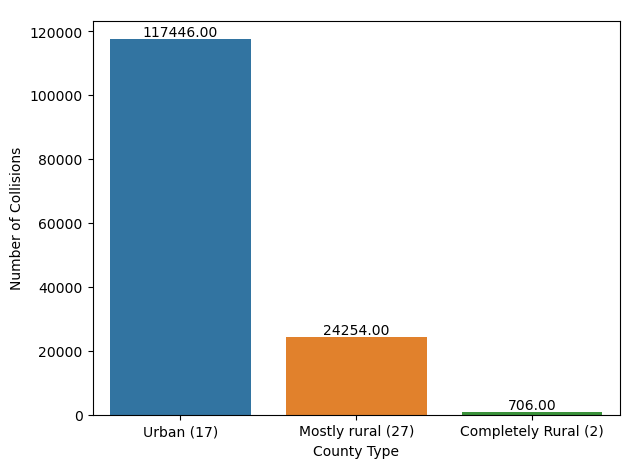

In [71]:
ax = sns.barplot(merged_df, x=rural_urban, y= total_collisions)

for container in ax.containers:
    ax.bar_label(container, fmt='\n%.2f', label_type='edge')

plt.xlabel('County Type')
plt.ylabel('Number of Collisions')

plt.tight_layout()

plt.show()

([<matplotlib.patches.Wedge at 0x165e0ddd0>,
 [Text(-0.9374099280345173, 0.5755541910387947, 'Urban (17)'),
  Text(0.9283323384933078, -0.5900839510675975, 'Mostly rural (27)'),
  Text(1.0998665823299336, -0.01713187304037374, 'Completely Rural (2)')])

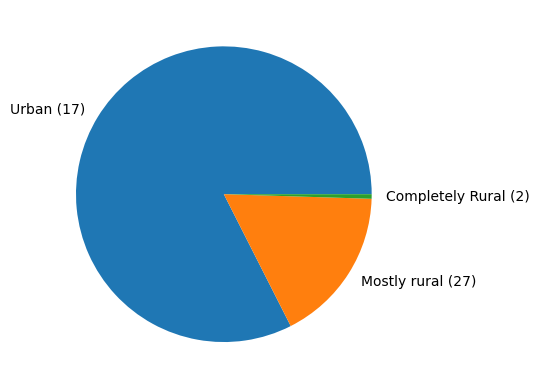

In [47]:
plt.pie(total_collisions, labels=rural_urban, colors=None)